I'm going to make the kinship matrix in this notebook. Since many previous methods expect 
array data, I'm going to start by making a kinship matrix using our HumanCoreExome arrays and
comparing the kinship matrix to our pedigrees. Then I'll try using the WGS data; I'll probably
restrict to markers in the array. Then I can compare between the array and WGS kinship matrices.

In [2]:
import os
import subprocess

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline

In [3]:
sns.set_context('talk')

In [4]:
outdir = os.path.join(ciepy.root, 'output',
                      'kinship_matrix')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'kinship_matrix')
cpy.makedir(private_outdir)

In [5]:
array_meta = pd.read_table(os.path.join(ciepy.root, 'data', 'array_metadata.tsv'),
                           index_col=0)
wgs_meta = pd.read_table(os.path.join(ciepy.root, 'data', 'wgs_metadata.tsv'),
                         index_col=0)

# Array Kinship Matrix

I'll make a kinship matrix using the blood/fibroblast arrays for each person.

In [6]:
array_vcf = os.path.join(ciepy.root, 'private_data', 'exome_array', 'array_kinship.vcf.gz')

array_kmatrix = os.path.join(outdir, 'array.kin')
if not os.path.exists(array_kmatrix):
    c = ('{} make-kin --vcf {} --min-maf 0.01 --min-callrate 0.95 '
         '--out {} --run 10'.format(cpy.epacts, array_vcf, array_kmatrix))
    subprocess.check_call(c, shell=True)

array_kdump = os.path.join(outdir, 'array.kindump')
if not os.path.exists(array_kdump):
    c = ('{}/pEmmax kin-util --kinf {} --outf {} --dump'.format(
        os.path.split(cpy.epacts)[0], array_kmatrix, os.path.splitext(array_kdump)[0]))
    subprocess.check_call(c, shell=True)

In [7]:
akmatrix = pd.read_table(array_kdump)

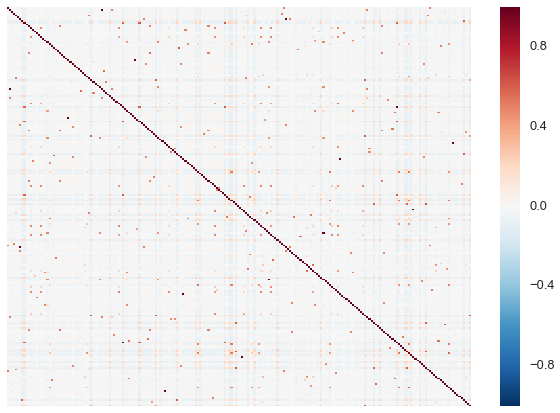

In [8]:
sns.heatmap(akmatrix, xticklabels=False, yticklabels=False, linewidths=0);

# WGS Kinship Matrix

I'll make a kinship matrix using the WGS data. I'm going to restrict to SNPs on the array.

In [9]:
wgs_vcf = os.path.join(ciepy.root, 'private_data', 'wgs', 'kinship', '0000.vcf.gz')

wgs_kmatrix = os.path.join(outdir, 'wgs.kin')
if not os.path.exists(wgs_kmatrix):
    c = ('{} make-kin --vcf {} --min-maf 0.01 --min-callrate 0.95 '
         '--out {} --run 10'.format(cpy.epacts, wgs_vcf, wgs_kmatrix))
    subprocess.check_call(c, shell=True)

wgs_kdump = os.path.join(outdir, 'wgs.kindump')
if not os.path.exists(wgs_kdump):
    c = ('{}/pEmmax kin-util --kinf {} --outf {} --dump'.format(
        os.path.split(cpy.epacts)[0], wgs_kmatrix, os.path.splitext(wgs_kdump)[0]))
    subprocess.check_call(c, shell=True)

In [21]:
wgskmatrix = pd.read_table(wgs_kdump)

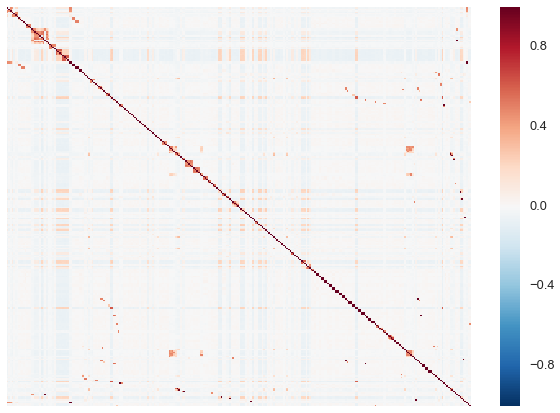

In [11]:
sns.heatmap(wgskmatrix, xticklabels=False, yticklabels=False, linewidths=0);

# Compare Array to WGS Kinship Matrix

I'll convert the indices of the kinship matrix to subject IDs for comparison.

In [12]:
wgskmatrix = wgskmatrix.ix[wgs_meta.index, wgs_meta.index]
wgskmatrix.index = wgs_meta.subject_id
wgskmatrix.columns = wgs_meta.subject_id

In [25]:
wgs_meta.shape

(220, 3)

It seems that there is an error for 9c465690-fe72-468b-b9bf-5be5f2b92ebd in the 
merged VCF file. I need to check the UUIDs I assigned versus the file list, 
sample names, etc.

In [22]:
set(wgs_meta.index) - set(wgskmatrix.columns)

{'9c465690-fe72-468b-b9bf-5be5f2b92ebd',
 'b867265b-46b9-4e38-bcd0-90dc049dcc69'}

In [13]:
s = set(array_meta.subject_id) - set(wgs_meta.subject_id)
array_meta = array_meta.drop(array_meta[array_meta.subject_id.apply(lambda x: x in s)].index)
akmatrix = akmatrix.ix[array_meta.index, array_meta.index]
akmatrix.index = array_meta.subject_id
akmatrix.columns = array_meta.subject_id
akmatrix = akmatrix.ix[wgskmatrix.index, wgskmatrix.index]

In [14]:
akmatrix.shape

(220, 220)

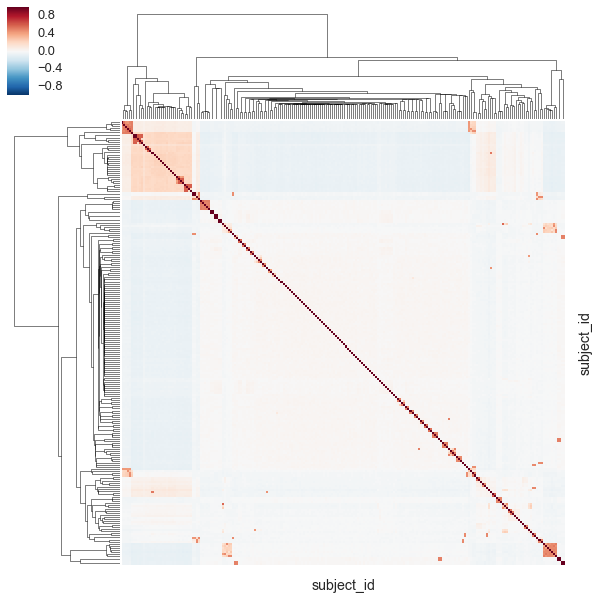

In [15]:
sns.clustermap(akmatrix, xticklabels=False, yticklabels=False, linewidths=0);

In [16]:
wgskmatrix.shape

(220, 220)

In [20]:
wgskmatrix.dropna().shape

(0, 220)

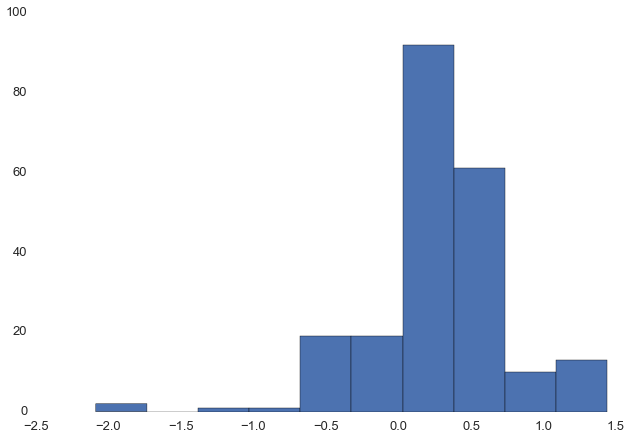

In [19]:
wgskmatrix.sum().hist()

In [ ]:
sns.clustermap(wgskmatrix, xticklabels=False, yticklabels=False, linewidths=0);

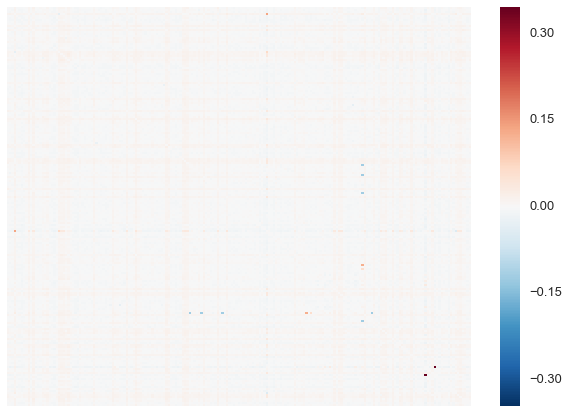

In [107]:
sns.heatmap(wgskmatrix - akmatrix, xticklabels=False, yticklabels=False, linewidths=0);

In [108]:
diff = wgskmatrix - akmatrix

In [109]:
diff.max()

2fdcaed0-53ec-419b-8779-6a826d8c10bb    0.01647
f549b5fa-a6c0-49fb-8a07-dda4f72ff076    0.01435
f80deca1-0641-4a52-86b5-7b01c227ba8a    0.01120
5482a5d3-6f16-483b-9c14-ca2f838d6af9    0.13549
17e14381-d098-400d-a4c8-9e635a55293a    0.00982
11c5e9cc-f702-4c47-91fd-201346ab5a3c    0.01273
7b9ab90a-4836-4d23-856a-8213b97e05ee    0.00610
62d833a3-87c8-40a2-8261-d172f4c0e7fe    0.01111
0c6ef005-c904-49f1-9308-8169046c0fa2    0.01187
0c0a6edd-427f-4882-acfd-d21456416649    0.03063
35bdd022-52cd-43e0-a658-3ea802787462    0.01321
b7af5d94-4b4a-4130-94ee-fc1f23c5824a    0.03594
64c58f58-a121-413d-8257-294b229dd4c0    0.01127
5bdb8207-56ec-4f2e-add3-3ce3fbd4b1e0    0.01372
af5ba1a2-837e-42e6-9afa-16207886c776    0.00966
10479353-d46d-478d-86f0-c6be025de81b    0.01593
2f63f491-a9f2-4177-b2a1-c3d21ed9c247    0.01559
fabb1fba-dea1-44a5-a9c2-e40b46011c7a    0.01873
416e2905-329b-44ed-bb02-8a3b1ed6847e    0.01132
52bea4e8-baff-49b0-9ab0-fee9b9c527aa    0.00858
cf2564c4-c49c-462f-8687-50998ab0db54    

TODO: Look into samples that have differences between array and WGS kinship.